# Preliminary studies --> the working version

**!!! The deal was: !!!** the time window has to be constant for both the beams, else it will pump energy somewhere in the spectrum because of the periodicity assumption in the DFT

CAVEAT:
arrays here are ~2^30 long, so first think and then evaluate the cell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Particle distributions:

## Gaussian:

$$
f(x) = \frac{N e}{\sigma \sqrt{2 \pi}} e^{-\frac{(x-\mu)^2}{\sigma^2} }
$$

works fine because it is already normalised to 1, so just multiplicate for the charge to get current

## Cosine square

$$
f(x) = cos^2(\frac{\pi}{4\sigma} x), \qquad \text{for a period only} 
$$

now this is not normalised to one! So computing: $$\int_{-\frac{\pi}{2}}^\frac{\pi}{2} cos^2(x) dx = \frac{1}{2} (x+sin(x)cos(x)) = \frac{\pi}{2}$$

and so similarly 
$$\int_{-2\sigma}^{2\sigma} cos^2(\frac{\pi}{4\sigma} x) dx = \frac{x}{2} + \frac{\sigma}{4}sin(\frac{\pi}{4\sigma} x) = 2\sigma$$

so the function has to be normalised multiplying for $\frac{1}{2\sigma}$ and it is 

$$
f(x) = \frac{1}{2\sigma} cos^2(\frac{\pi}{4\sigma} x)
$$

In [2]:
def gaussian_shape(x, mu, sig):
    return 1./((sig*np.sqrt(np.pi*2))) * np.exp(-0.5*((x-mu)/sig)**2)

def current(x, N, mu, sig):
    from scipy.constants import e
    return e*N*gaussian_shape(x, mu, sig )

def dB(x):
    return 20*np.log10(x)

In [3]:
def cos2_shape(x, sigma):
    a = np.pi/(4*sigma)
    
    full_out = (1./2. / sigma)*np.cos(a*x)**2
    full_out[x<-2*sigma] = 0.
    full_out[x>2*sigma] = 0.
    
    return full_out

def cos2_current(x, N, sig):
    from scipy.constants import e
    return e*N*cos2_shape(x, sig)

In [4]:
def doFFT(t, y):
    assert t.size == y.size
    dt = np.abs(t[1]-t[0])
    N_sample = t.size
    
    norm = 2/N_sample
    
    s_fft = norm*np.abs(np.fft.fft(y))
    f_fft = np.fft.fftfreq(N_sample, d=dt)
    df = np.abs(f_fft[1]-f_fft[0])

    return f_fft, s_fft

In [5]:
def coulomb_to_N(charge):
    '''
    Total bunch charge [C] to number of particles per bunch N
    '''
    from scipy.constants import e
    return charge/e

In [10]:
 coulomb_to_N(0.6e-9)*1e-10

0.37449054755299543

Integral=0.9999999999990906
Integral=0.999999426710126


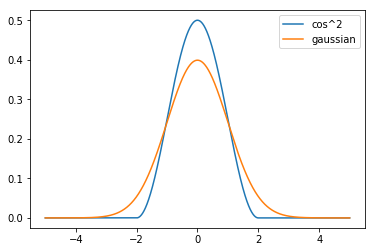

In [134]:
# distribution checks
sigma_p = 1.

tscale = np.linspace(-5*sigma_p, 5*sigma_p, 2**20)
dt = tscale[1]-tscale[0]

plt.plot(tscale, cos2_shape(tscale, sigma_p),label='cos^2')
print('Integral='+str(np.sum(cos2_shape(tscale, sigma_p)*dt)))
plt.plot(tscale, gaussian_shape(tscale, 0., sigma_p),label='gaussian')
print('Integral='+str(np.sum(gaussian_shape(tscale, 0., sigma_p)*dt)))
plt.legend(frameon=True)


# Beam distribution comparison

In [135]:
sigma_p = 0.25e-9
Np = 3e11

tscale = np.linspace(-30*sigma_p, 30*sigma_p, 2**22)

In [136]:
dt = np.abs(tscale[1]-tscale[0])
yy_p_cos2 = cos2_current(tscale, Np, sigma_p)
yy_p_gauss = current(tscale, Np, 0., sigma_p)

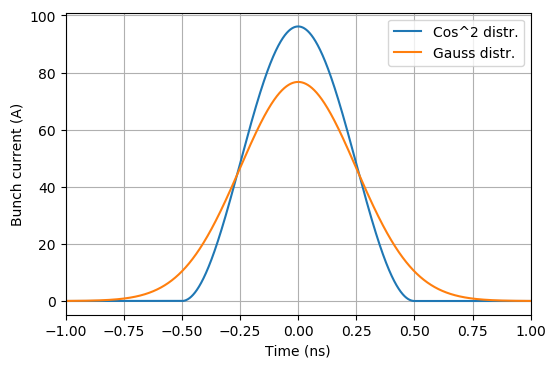

In [137]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(1e9*tscale, yy_p_cos2,label='Cos^2 distr.')
ax.plot(1e9*tscale, yy_p_gauss,label='Gauss distr.')
ax.set_xlim(-1,1)
# ax.set_ylim(-50,30)
# ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Bunch current (A)')
ax.set_xlabel('Time (ns)')
ax.legend(frameon=True)
plt.savefig('ideal_time_domain.png',format='png',dpi=300)

In [138]:
ff_p_cos2, sf_p_cos2 = doFFT(tscale,yy_p_cos2)
ff_p_gauss, sf_p_gauss = doFFT(tscale,yy_p_gauss)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


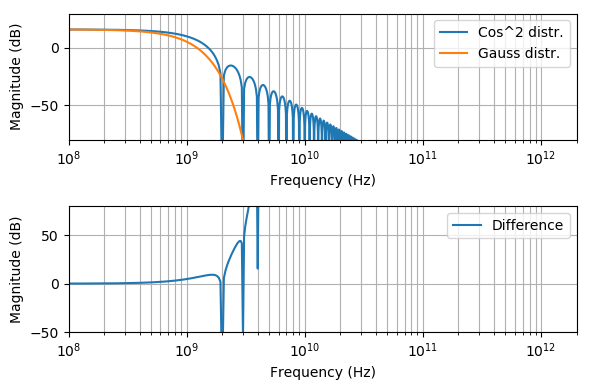

In [148]:
fig, ax = plt.subplots(2, dpi=100)
ax[0].plot(ff_p_cos2, dB(sf_p_cos2),label='Cos^2 distr.')
ax[0].plot(ff_p_gauss, dB(sf_p_gauss),label='Gauss distr.')
ax[0].set_xlim(1e8, 2e12)
ax[0].set_ylim(-80,30)
ax[0].set_xscale('log')
ax[0].grid(which='both')
ax[0].set_ylabel('Magnitude (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend(frameon=True)

ax[1].plot(ff_p_gauss, dB(sf_p_cos2) - dB(sf_p_gauss),label='Difference')
ax[1].set_xlim(1e8, 2e12)
ax[1].set_ylim(-50,80)
ax[1].set_xscale('log')
ax[1].grid(which='both')
ax[1].set_ylabel('Magnitude (dB)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].legend(frameon=True)

plt.tight_layout()
plt.savefig('ideal_freq_domain_cos2vsgauss.png',format='png',dpi=300)

# ok now with electrons also

In [169]:
sigma_p = 0.25e-9
sigma_e = 1e-12
Np = 3e11
Ne = coulomb_to_N(0.6e-9)

tscale = np.linspace(-10*sigma_p, 10*sigma_p, 2**26)

In [170]:
dt = np.abs(tscale[1]-tscale[0])
yy_p_cos2 = cos2_current(tscale, Np, sigma_p)
yy_p_gauss = current(tscale, Np, 0., sigma_p)
yy_e = current(tscale, Ne, 0., sigma_e)

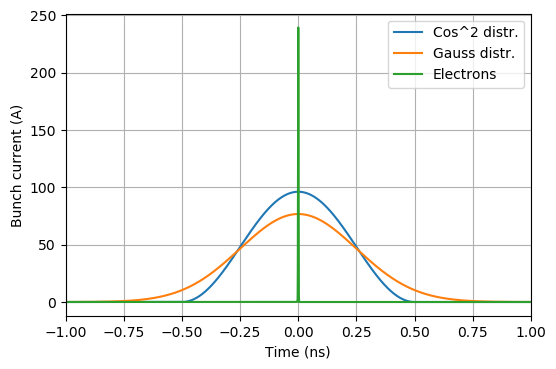

In [171]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(1e9*tscale, yy_p_cos2,label='Cos^2 distr.')
ax.plot(1e9*tscale, yy_p_gauss,label='Gauss distr.')
ax.plot(1e9*tscale, yy_e,label='Electrons')
ax.set_xlim(-1,1)
# ax.set_ylim(-50,30)
# ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Bunch current (A)')
ax.set_xlabel('Time (ns)')
ax.legend(frameon=True)
plt.savefig('ideal_time_domain.png',format='png',dpi=300)

In [172]:
ff_p_cos2, sf_p_cos2 = doFFT(tscale,yy_p_cos2)
ff_p_gauss, sf_p_gauss = doFFT(tscale,yy_p_gauss)
ff_e, sf_e = doFFT(tscale,yy_e)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


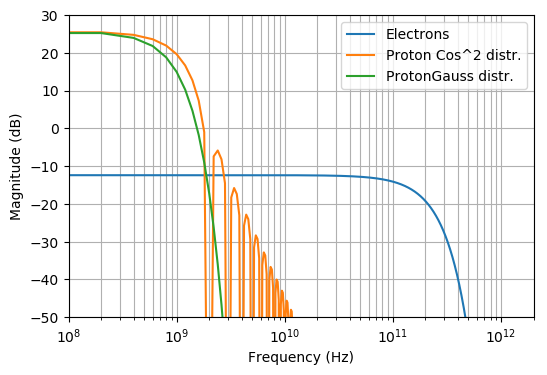

In [173]:
fig, ax = plt.subplots(1, dpi=100)
ax.plot(ff_e, dB(sf_e),label='Electrons')
ax.plot(ff_p_cos2, dB(sf_p_cos2),label='Proton Cos^2 distr.')
ax.plot(ff_p_gauss, dB(sf_p_gauss),label='ProtonGauss distr.')
ax.set_xlim(1e8, 2e12)
ax.set_ylim(-50,30)
ax.set_xscale('log')
ax.grid(which='both')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency (Hz)')
ax.legend(frameon=True)
plt.savefig('ideal_freq_domain.png',format='png',dpi=300)